In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import wfdb
import os
from pathlib import Path
import pywt
from pywt import wavedec
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

In [119]:
dataset_directory = Path("C:/Users/lalikumar/Downloads/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0")

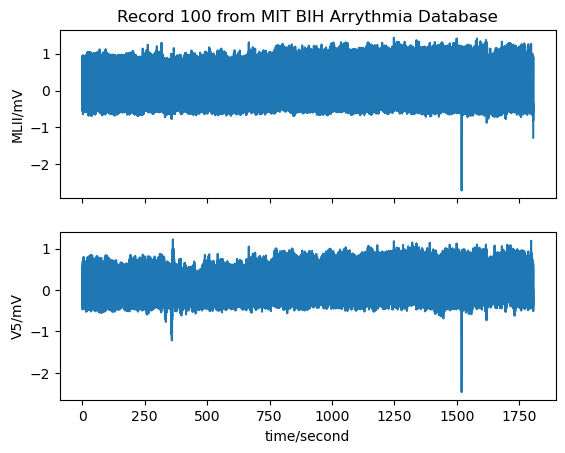

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

In [120]:
# Demo 1 - Read a WFDB record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord(dataset_directory / '100') 
wfdb.plot_wfdb(record=record, title='Record 100 from MIT BIH Arrythmia Database') 
display(record.__dict__)

In [187]:
# Demo 2 - Read certain channels and sections of the WFDB record using the simplified 'rdsamp' function
# which returns a numpy array and a dictionary. Show the data.
signals, fields = wfdb.rdsamp(dataset_directory / '100', channels=[0, 1], sampfrom=100, sampto=15000)
display(signals)
display(fields)


array([[-0.33 , -0.195],
       [-0.335, -0.185],
       [-0.33 , -0.185],
       ...,
       [-0.52 , -0.275],
       [-0.54 , -0.315],
       [-0.545, -0.31 ]])

{'fs': 360,
 'sig_len': 14900,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}

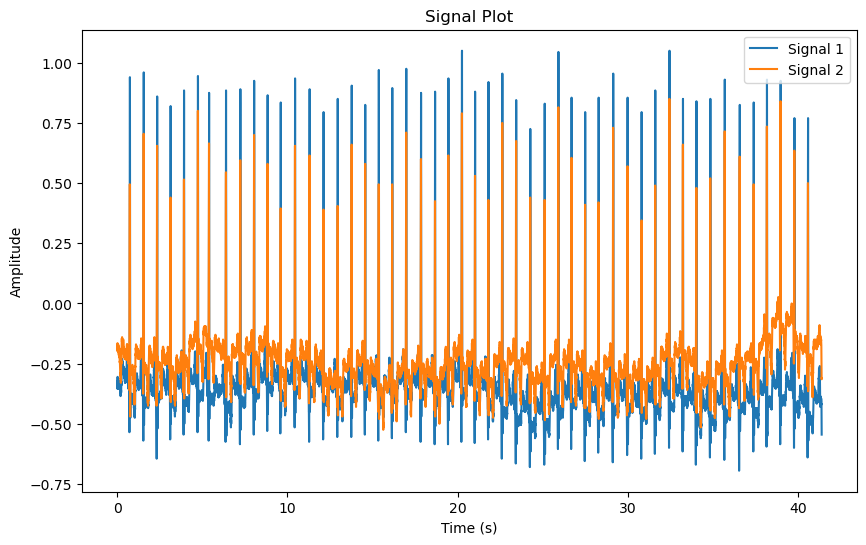

In [188]:
# Extract signal data
signal_1 = signals[:, 0]
signal_2 = signals[:, 1]

# Extract sampling frequency and number of samples
fs = fields['fs']
n_samples = fields['sig_len']

# Calculate time array
time = np.arange(n_samples) / fs

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(time, signal_1, label='Signal 1')
plt.plot(time, signal_2, label='Signal 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal Plot')
plt.legend()
plt.show()

In [361]:
ecg_signals = []

for file in dataset_directory.glob('*.dat'):
    print(file.stem)
    signals, fields = wfdb.rdsamp(dataset_directory / file.stem, channels=[1], sampfrom=100, sampto=15000)
    ecg_signals.append(signals)

ecg_signals = np.array(ecg_signals)
print(ecg_signals.shape)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234
(48, 14900, 1)


In [321]:
def plot_signal(signal): 

    # Extract sampling frequency and number of samples
    fs = fields['fs']
    signal_length = len(signal)

    # Calculate time array
    time = np.arange(signal_length) / fs

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.title('Signal Plot')
    plt.show()
    

In [326]:
def scale_signal(ecg_signal):
    # Find the minimum value in the signal
    min_val = np.min(ecg_signal)

    # Calculate the scaling factor to shift the signal above 0
    scaling_factor = abs(min_val) + 1  # Add 1 for a small margin

    # Scale the signal by adding the scaling factor
    scaled_signal = ecg_signal + scaling_factor

    return scaled_signal

In [328]:
ecg_signal = ecg_signals[0]
scaled_ecg_signal = scale_signal(ecg_signal)

$$
 W(a, b) = \frac{1}{\sqrt{a}} \int_{-\infty}^{\infty} x(t) \Psi^*\left(\frac{t-b}{a}\right) dt
$$

In [329]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca], [0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca], [0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y[:, 1]

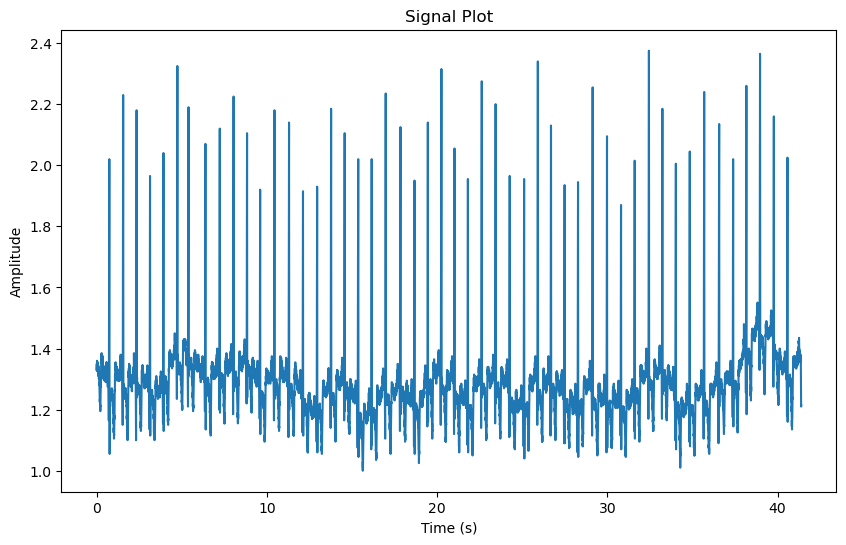

In [330]:
plot_signal(scaled_ecg_signal)

c:\Users\lalikumar\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


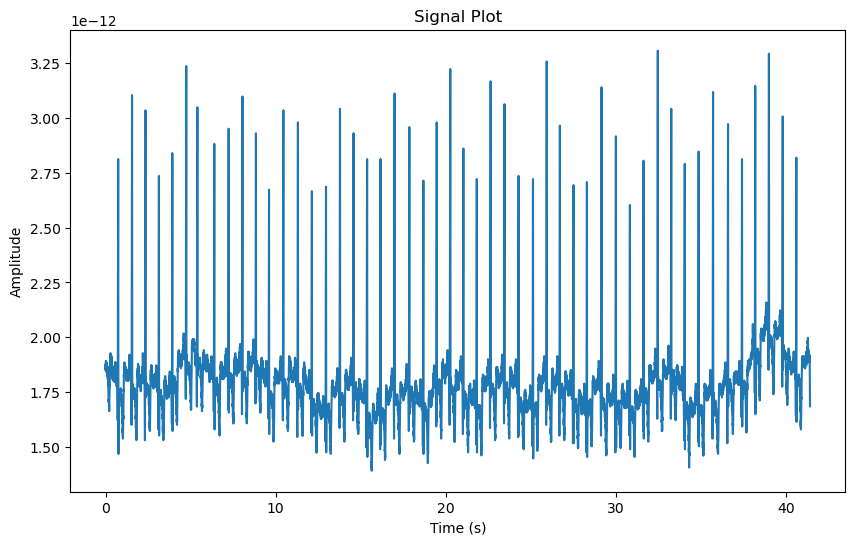

In [332]:
denoised_signal = denoise_signal(scaled_ecg_signal, 'bior4.4',4, 1, 7)
plot_signal(denoised_signal)

In [351]:
def remove_baseline_wander(ecg_signal, sampling_frequency, cutoff_frequency = 1.2, filter_order=3):
    nyquist_frequency = 0.5 * sampling_frequency
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design a high-pass Butterworth filter
    b, a = signal.butter(filter_order, normalized_cutoff, btype='high', analog=False)

    # Apply the high-pass filter to remove baseline wander
    baseline_removed_signal = signal.filtfilt(b, a, ecg_signal, padlen = 0)

    return baseline_removed_signal

In [352]:
sampling_frequency = fields['fs']
baseline_removed_signal = remove_baseline_wander(scaled_ecg_signal, sampling_frequency)

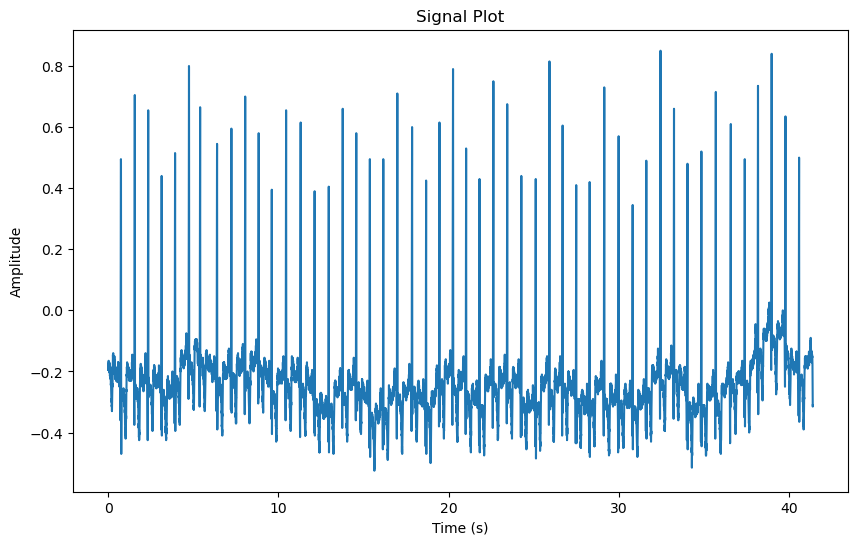

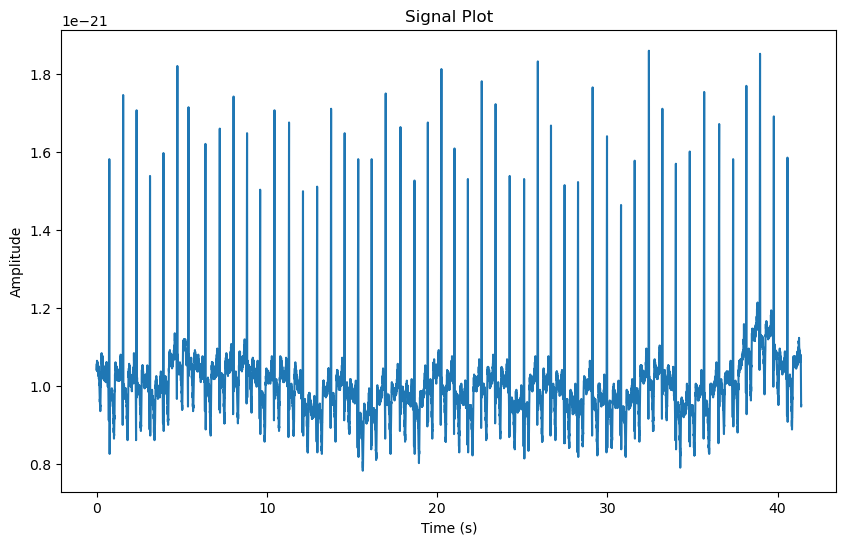

In [353]:
plot_signal(ecg_signal)
plot_signal(baseline_removed_signal)

c:\Users\lalikumar\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


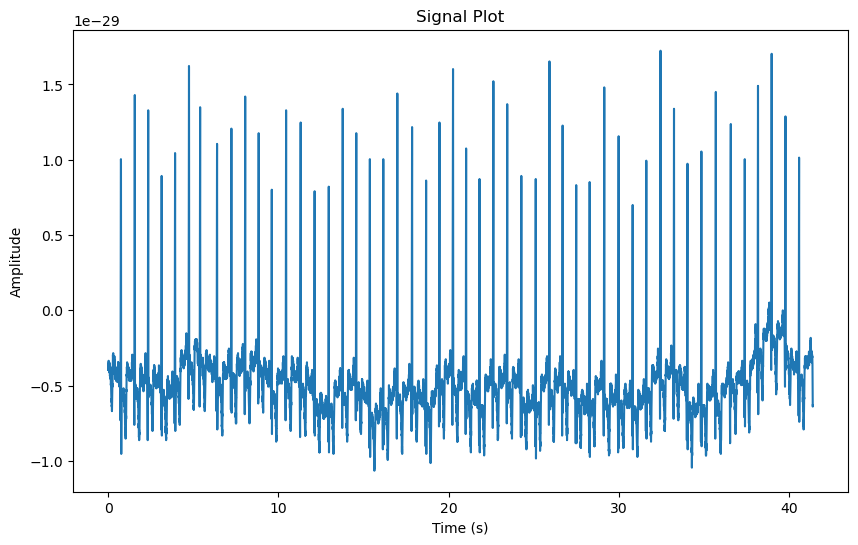

In [258]:
denoised_signal = denoise_signal(baseline_removed_signal, 'sym6', 4, 1, 7)
plot_signal(denoised_signal)

In [151]:
def normalize_signal(signal):
    scaler = MinMaxScaler()
    signal = signal.reshape(-1, 1)
    scaled_signal = scaler.fit_transform(signal)
    return scaled_signal
    

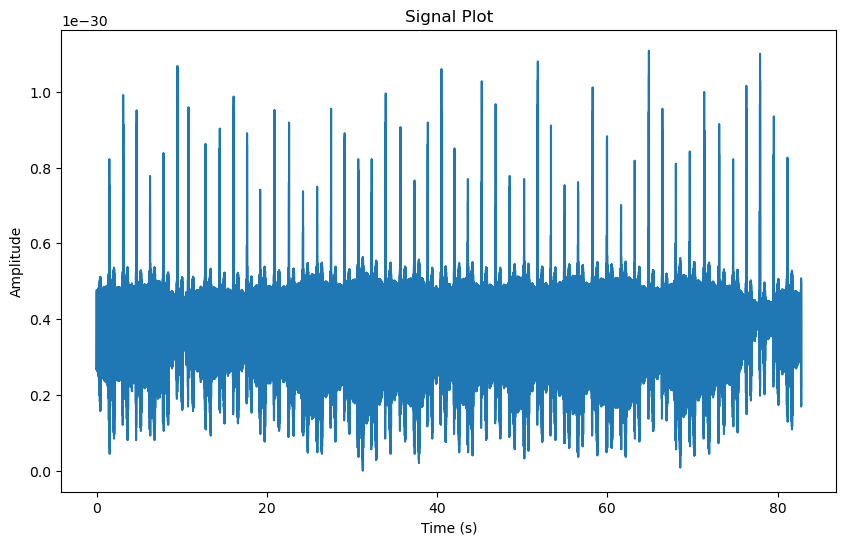

In [178]:
normalized_signal = normalize_signal(denoised_signal)
plot_signal(normalized_signal)

In [355]:
# X = []

# for ecg_signal in signals:
#     denoised_signal = denoise_signal(ecg_signal, 'bior4.4', 4, 1, 7)
#     filtered_signal = remove_baseline_wander(denoised_signal, sampling_frequency)
#     normalized_signal = normalize_signal(filtered_signal) 
#     X.append(normalized_signal)
# print(X.shape)

In [449]:
labels = []

for file in dataset_directory.glob('*.atr'):
    print(file.stem)
    annotations = wfdb.rdann(str(dataset_directory / file.stem), 'atr', sampto=15000)
    diagnosis = annotations.aux_note
    labels.append(diagnosis)

print(labels)

100
101
102-0
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234
[['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(P\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], ['(P\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''

In [450]:
labels = [[item.strip().replace('\x00', '') for item in inner_list if item.strip()] for inner_list in labels]

labels = [[item.replace('(', '') for item in inner_list] for inner_list in labels]
print(labels)
print(len(labels))

[['N'], ['N'], ['P'], ['P'], ['N'], ['P'], ['N'], ['N'], ['P'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N'], ['N', 'B', 'N', 'B'], ['N'], ['N'], ['N'], ['N'], ['B', 'N', 'B'], ['AFIB'], ['N'], ['AFIB'], ['N'], ['B', 'VT', 'N', 'VFL'], ['N'], ['N'], ['AFIB'], ['N'], ['N'], ['N'], ['N'], ['P'], ['AFIB'], ['N'], ['AFIB'], ['N'], ['N'], ['N', 'B', 'N'], ['N', 'PREX', 'N', 'PREX', 'N', 'PREX'], ['N', 'MISSB'], ['SBR'], ['N', 'VT', 'N'], ['N']]
49


In [451]:
labels_dict = {'N': 0, 'P': 1, 'B': 2, 'AFIB': 3, 'MISSB': 4, 'PREX': 5, 'VT': 6, 'VFL': 7, 'SBR': 8}
labels = [[labels_dict.get(k) for k in lst] for lst in labels]
print(labels)


[[0], [0], [1], [1], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 2, 0, 2], [0], [0], [0], [0], [2, 0, 2], [3], [0], [3], [0], [2, 6, 0, 7], [0], [0], [3], [0], [0], [0], [0], [1], [3], [0], [3], [0], [0], [0, 2, 0], [0, 5, 0, 5, 0, 5], [0, 4], [8], [0, 6, 0], [0]]


In [453]:
labels = [[label[0]] for sublist in labels for label in [sublist]]
print(labels)
labels = np.array(labels)

[[0], [0], [1], [1], [0], [1], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [2], [3], [0], [3], [0], [2], [0], [0], [3], [0], [0], [0], [0], [1], [3], [0], [3], [0], [0], [0], [0], [0], [8], [0], [0]]
